# %% [markdown]

# Descripción del proyecto
La compañía Sweet Lift Taxi ha recopilado datos históricos sobre
pedidos de taxis en los aeropuertos. Para atraer a más conductores durante
las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora.
Construye un modelo para dicha predicción.
La métrica RECM en el conjunto de prueba no debe ser superior a 48.
## Instrucciones del proyecto.
1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros.
La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.
## Descripción de los datos
Los datos se almacenan en el archivo `taxi.csv`.
El número de pedidos está en la columna `num_orders`.

# %% [markdown]

# 1. Preparacion

In [ ]:
# %%

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# %% [markdown]

# Carga de los datos.

In [ ]:
# %%

df_taxi = pd.read_csv(r'../../../datasets/taxi.csv')

# %% [markdown]

# 2. Análisis

# %% [markdown]

## Observación general de los datos.

In [ ]:
# %%

df_taxi.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [ ]:
# %%

df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


# %% [markdown]

Obervamos que los datos se cargaron correctamente.
El DataFrame 26,406 filas por 2 columnas, del cual no hay ningún registro nulo.
el tipo de valores que tiene nuestro dataframe es object e int64. Dado que tenemos una columa llamada datetime,
cambiar esta columna al formato correspondiente. También observamos el número de viajes registrados es
cada 10 minutos.

# %% [markdown]

## Obervación estadística de los datos antes del remuestreo.

In [ ]:
# %%

df_taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


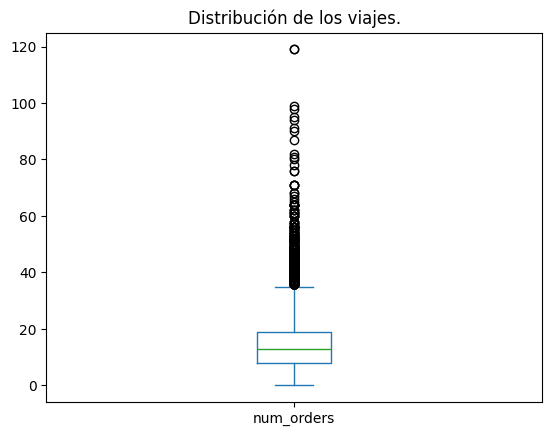

In [ ]:
# %%

df_taxi.plot(kind='box', title='Distribución de los viajes.')
plt.show()

# %% [markdown]

En la descripción estadística observamos que
los datos se encuentran ligeramente sesgados a la derecha;
sin embargo, no es un problema para seguir adelante. El número total de viajes fue de 26,496,
hubo registros con cero viajes,
y la cantidad máxima de viajes en una hora y día específicos fue de 119.

# %% [markdown]

## Cambiar formato fecha y hacer remuestreo por una hora.

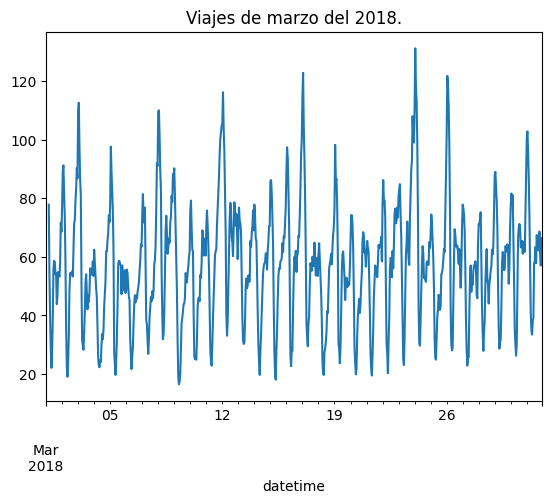

In [ ]:
# %%

df_taxi['datetime'] = pd.to_datetime(df_taxi['datetime'])
df_taxi = df_taxi.set_index('datetime')
df_taxi = df_taxi.resample('1h').sum()
df = df_taxi.copy()
df.loc['2018-03']['num_orders'].rolling(5).mean().plot(title="Viajes de marzo del 2018.")
plt.show()

# %% [markdown]

En la gráfica podemos observar la cantidad de viajes regitrados
de los días de marzo a agosto.

# %% [markdown]

## Obervación estadística de los datos después del remuestreo.

In [ ]:
# %%

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [ ]:
# %%

df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


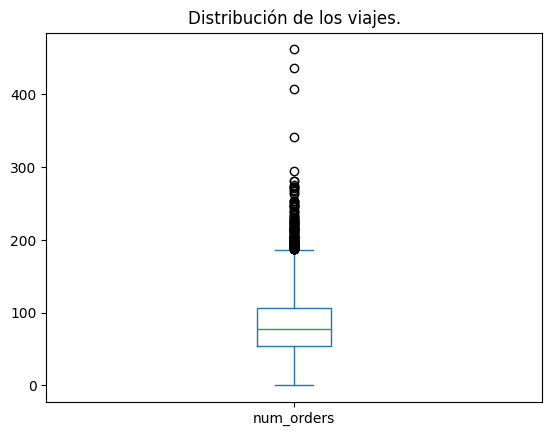

In [ ]:
# %%

df.plot(kind='box', title='Distribución de los viajes.')
plt.show()

# %% [markdown]

Después de haber hecho el remuestro aún tenemos datos atípicos.

In [ ]:
# %%

# Tendencia, estacionalidad y residuales.

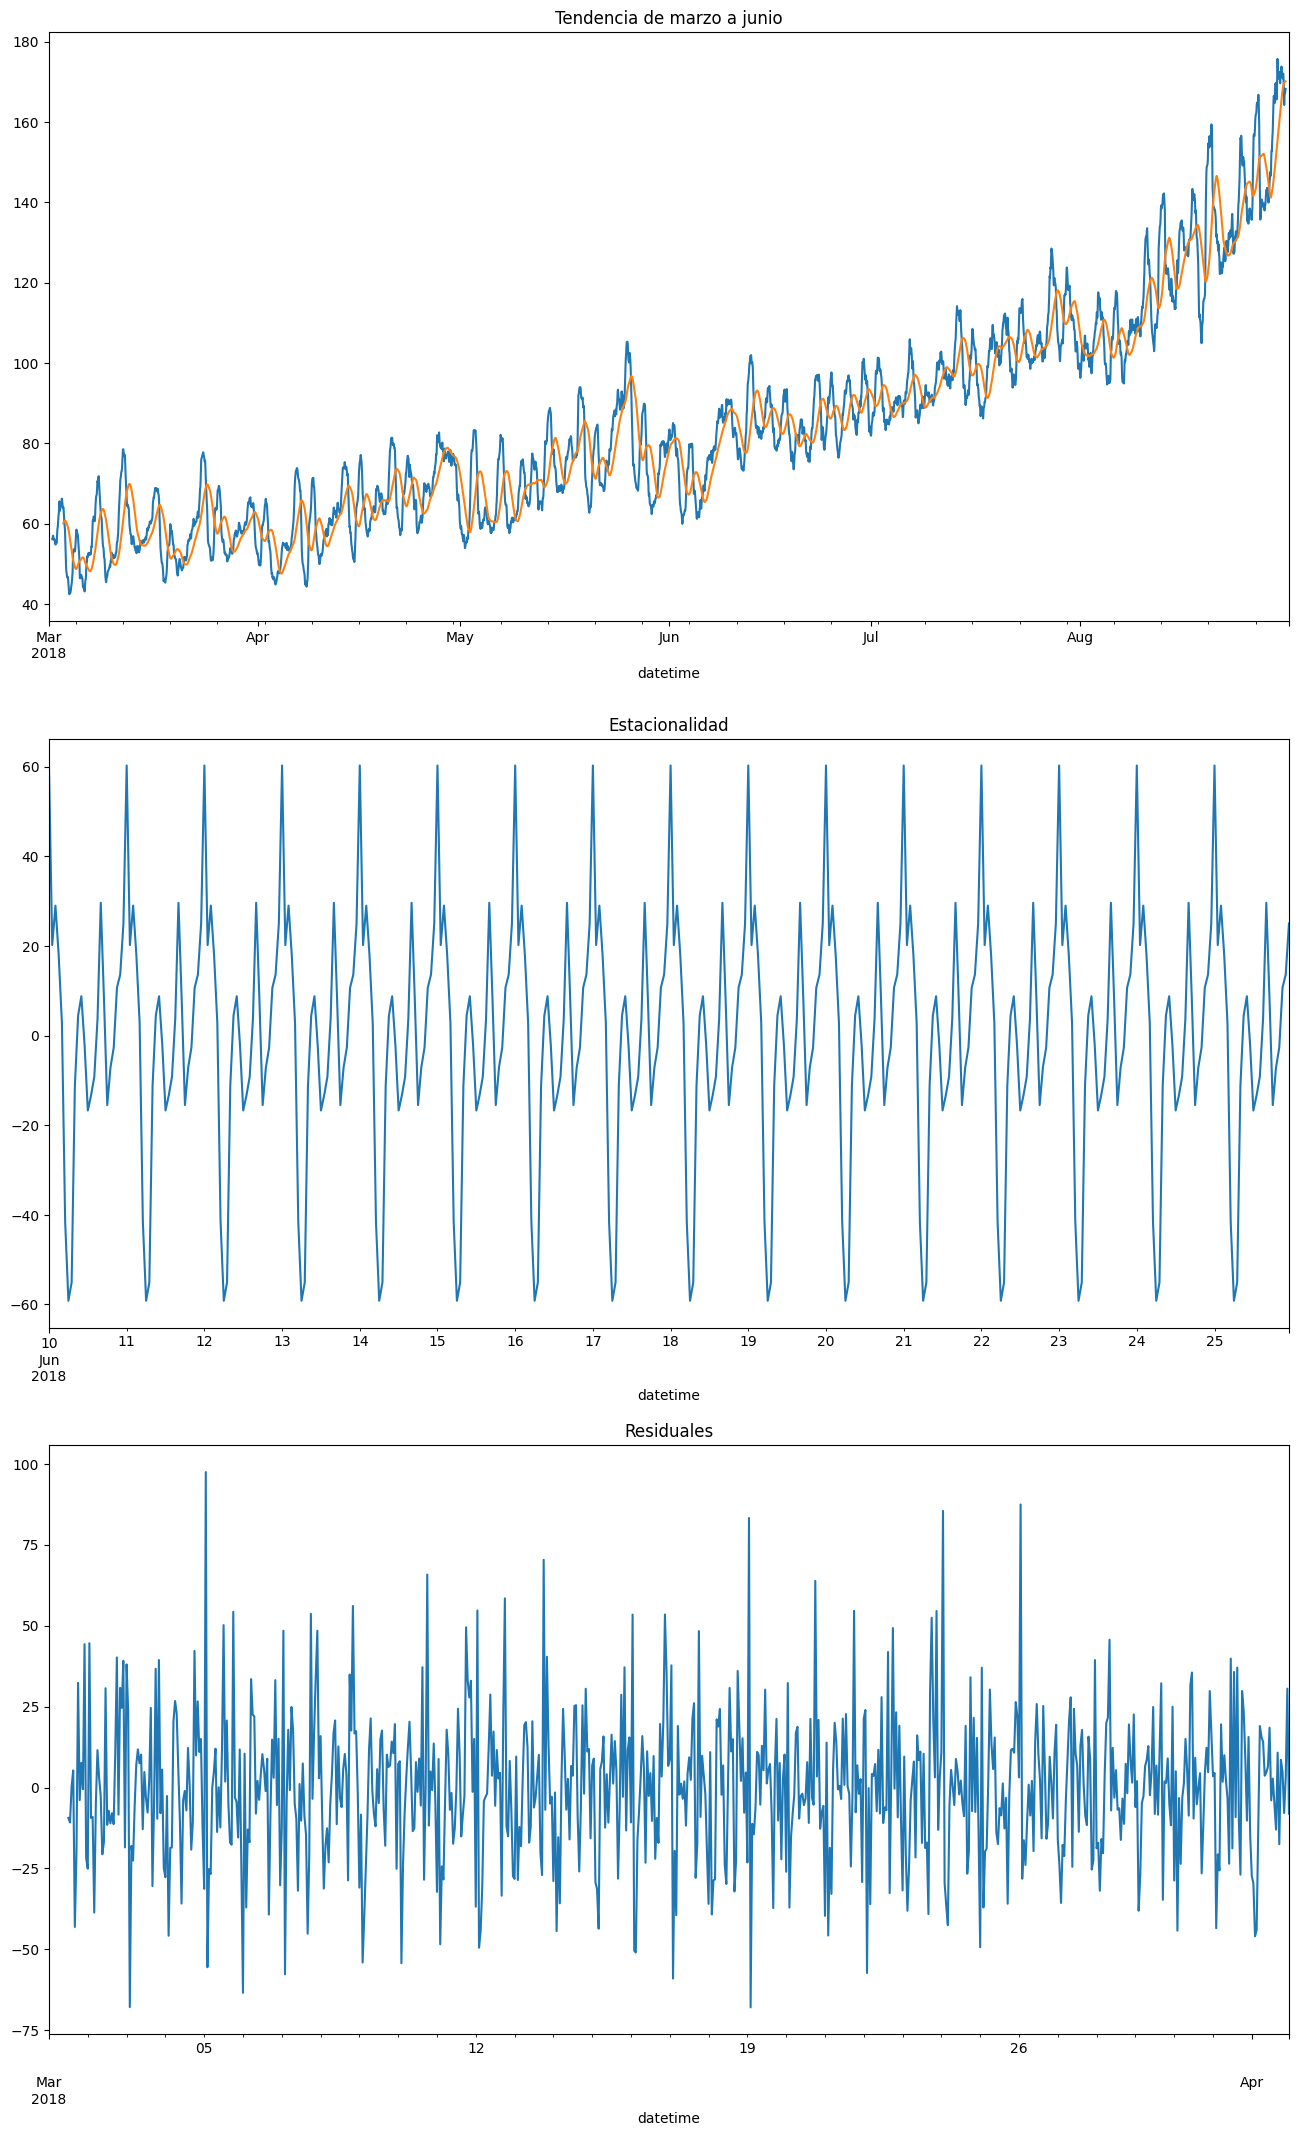

In [ ]:
# %%

decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(16, 26))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
decomposed.trend.rolling(40).mean().plot(ax=plt.gca())
plt.title('Tendencia de marzo a junio')
plt.subplot(312)
decomposed.seasonal['2018-06-10 00:00:00':'2018-06-25 23:00:00'].plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid['2018-03-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Residuales')
plt.show()

# %% [markdown]

- Tendencia: En la gráfica de tendencia podemos observar el incremento por hora en el número de viajes solicitados por los usuarios.
- Estacionalidad: En la gráfica de estacionalidad observamos que por la mañana hay menos órdenes;
al mediodía empiezan a aumentar hasta la noche, cuando comienzan a descender nuevamente a partir de la medianoche.
- Residuales: Ruido en los datos.

In [ ]:
# %%

decomposed.trend

datetime
2018-03-01 00:00:00   NaN
2018-03-01 01:00:00   NaN
2018-03-01 02:00:00   NaN
2018-03-01 03:00:00   NaN
2018-03-01 04:00:00   NaN
                       ..
2018-08-31 19:00:00   NaN
2018-08-31 20:00:00   NaN
2018-08-31 21:00:00   NaN
2018-08-31 22:00:00   NaN
2018-08-31 23:00:00   NaN
Freq: h, Name: trend, Length: 4416, dtype: float64

# %% [markdown]

## Hacer los datos mas estacionarios.

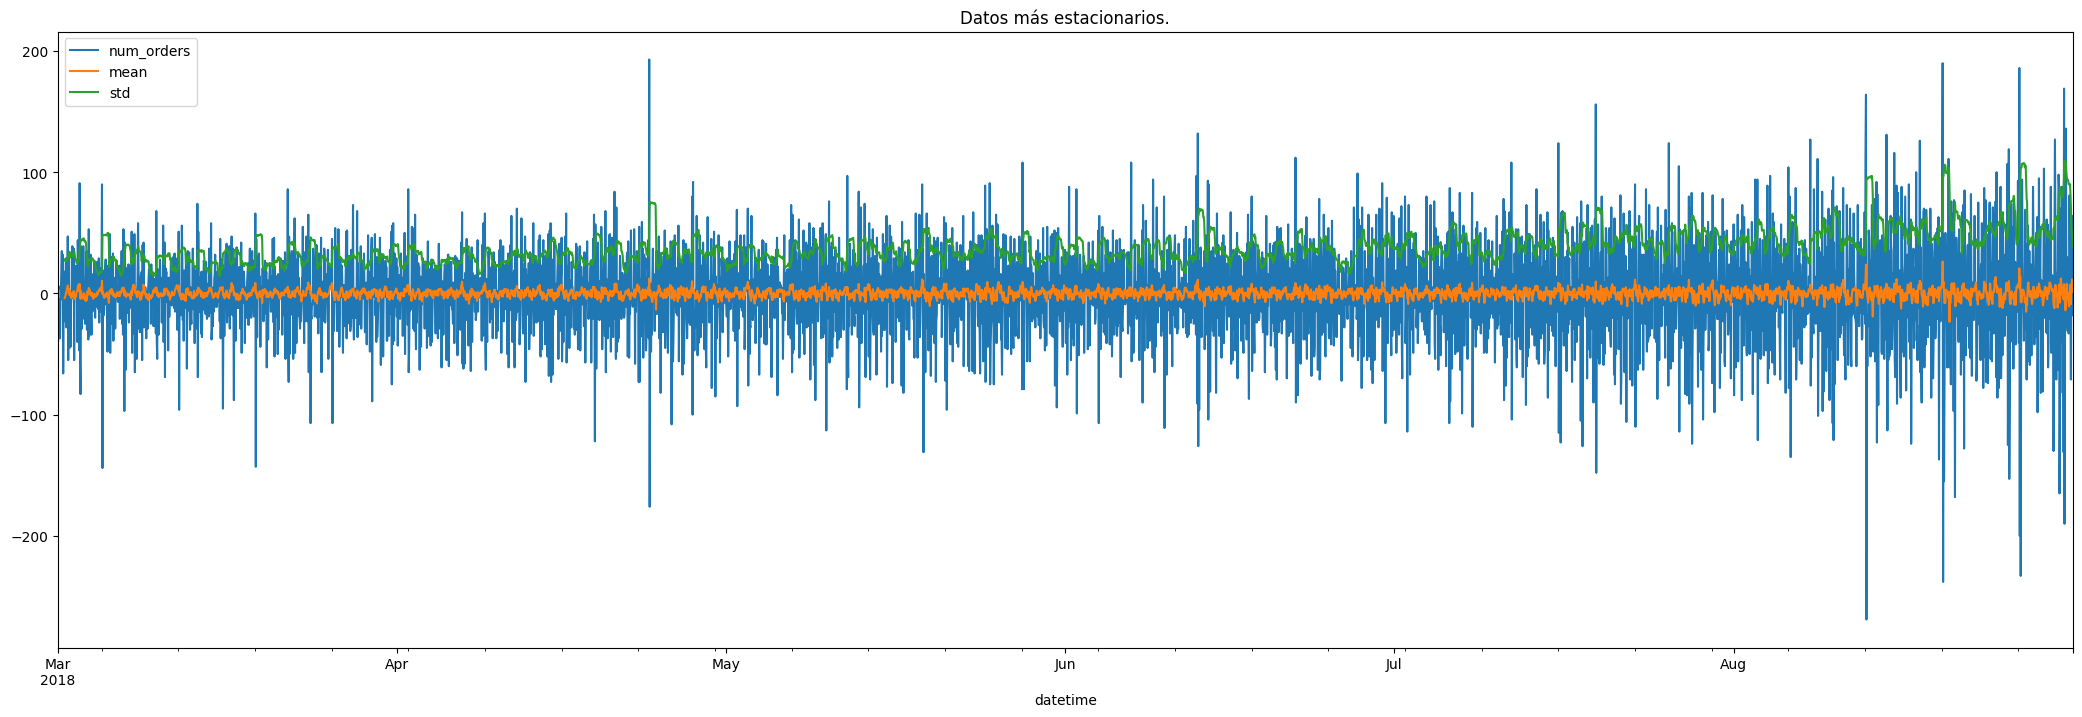

In [ ]:
# %%

data = df[['num_orders']].copy()
data -= data.shift()

data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()

data.plot(title='Datos más estacionarios.',figsize=(26, 8))
plt.show()

# %% [markdown]

# Funciones.

In [ ]:
# %%

# Grafica RMSE
def grafica_rmse(rmse_list, title=''):
    """Funcionn que grafica los RMSE gurdados en un lista e identifica el mejor de ellos.

    Args:
        rmse_list (npumy.array): lista de RMSE's obtenido de un modelo con diferentes hiperparametros y caracter´siticas del df
        title (str, optional): Título de la gráfica. Defaults to ''.
    """
    plt.plot(rmse_list)
    plt.plot(np.argmin(rmse_list), np.min(rmse_list),
             marker='*', markersize=15,
             label=f"Mejor RMSE: {np.min(rmse_list):.2f}")
    plt.title(title)
    plt.legend()
    plt.show()
    
# Creación de características para los modelos.
def make_features(data, max_lag, rolling_mean_size):
    """Desarrolador de caracter´sticas de una series temporal.

    Args:
        data (pandas.Dataframe): DataFrame en el cual se obtendrán las características
        max_lag (int): número máxima de retrasos que tendrán el DataFrame
        rolling_mean_size (int): Cantidad de máxima de promedio móvil

    Returns:
        _type_: _description_
    """
    new_data = data.copy()
    new_data['year'] = new_data.index.year
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek

    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = (
        new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    
    new_data = new_data.dropna()
    
    return new_data

# Dividir el conjunto de datos en formato de entrenamiento (90%) y prueba (10%) sin aletoriedad.
def splitting_data(data):
    """Dividie el dataset en entranamiento y prueba con proporcionón de 10 % en conjunto de prueba sin aleatoridad.

    Args:
        data (padnas.DataFrame): _description_

    Returns:
        tuple: features_train,target_train,features_test,target_test
    """
    
    train, test = train_test_split(data,test_size=0.1,shuffle=False,random_state=1234)
    train = train.dropna()
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train[['num_orders']]
    features_test = test.drop(['num_orders'], axis=1)
    target_test = test[['num_orders']]
    
    return features_train,target_train,features_test,target_test

# %% [markdown]

## 3. Formación

# %% [markdown]

### Prueba

# %% [markdown]

### Pruebas de cordura.

In [ ]:
# %%

train, test = train_test_split(df, test_size=0.1, shuffle=False)

# %% [markdown]

### Método 1.

In [ ]:
# %%

print(f"Viajes medios al día: {np.median(df)}")
pred_median = np.ones(test.shape) * np.median(train)
print('RMSE:', rmse(test, pred_median))

Viajes medios al día: 78.0
RMSE: 87.15277582981295


# %% [markdown]

### Método 2.

In [ ]:
# %%

print(f"Viajes medios al día: {np.median(df)}")
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RMSE:', rmse(test, pred_previous))

Viajes medios al día: 78.0
RMSE: 58.856486242815066


# %% [markdown]

En nuestra primera prueba de validación, obtuvimos un error considerablemente alto.
Sin embargo, al aplicar el método de *shifting* en la segunda prueba, logramos una mejora,
aunque aún no alcanzamos el objetivo de un RMSE de 49.
<br><br>
En los siguientes modelos buscaremos reducir este valor, generando nuevas características
a partir de la serie temporal. Los modelos que utilizaremos serán: Regresión Lineal,
Árboles de Decisión, Random Forest, CatBoost, LightGBM y XGBoost.
<br><br>
A continuación generaremos características temporales y ajustaremos los modelos antrerioemente mencionados y sus hiperparametros
iterativamente para predecir un objetivo.
En cada iteración, se ajustan los parámetros de max_lag y max_rolling, se evalúa el RMSE para el
conjunto de prueba, y se registra para graficarlo después de las n iteraciones y obtener el menor a 48 y el más cercano a cero.

# %% [markdown]

### Regresión Lineal.

RMSE para el conjunto de prueba con max_lag 2 y max_rolling 4: 52.60
RMSE para el conjunto de prueba con max_lag 4 y max_rolling 8: 52.87
RMSE para el conjunto de prueba con max_lag 6 y max_rolling 12: 53.13
RMSE para el conjunto de prueba con max_lag 8 y max_rolling 16: 53.88
RMSE para el conjunto de prueba con max_lag 10 y max_rolling 20: 56.11
RMSE para el conjunto de prueba con max_lag 12 y max_rolling 24: 51.03
RMSE para el conjunto de prueba con max_lag 14 y max_rolling 28: 51.25
RMSE para el conjunto de prueba con max_lag 16 y max_rolling 32: 52.37
RMSE para el conjunto de prueba con max_lag 18 y max_rolling 36: 53.12
RMSE para el conjunto de prueba con max_lag 20 y max_rolling 40: 54.21
RMSE para el conjunto de prueba con max_lag 22 y max_rolling 44: 52.97
RMSE para el conjunto de prueba con max_lag 24 y max_rolling 48: 47.18
RMSE para el conjunto de prueba con max_lag 26 y max_rolling 52: 46.81
RMSE para el conjunto de prueba con max_lag 28 y max_rolling 56: 46.42
RMSE para el

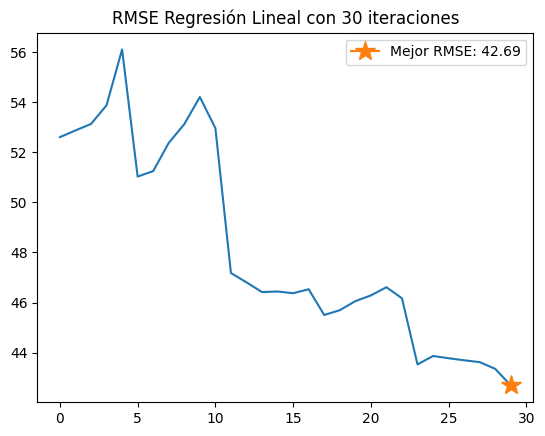

Número de características creadas para obtener el mejor RMSE: 65


In [ ]:
# %%

rmse_list = []
for x in range(30):
    new_data = make_features(df,2*(x+1),4*(x+1)) #genera nueva características.
    features_train, target_train,features_test, target_test = splitting_data(new_data) #Dividir el dataset 
                                                                                        #en conjunto de prueba y entramiento

    model = LinearRegression() #Modelo
    model.fit(features_train, target_train) #Predicción del modelo.
    pred_train = model.predict(features_train) #Predicción entrenamiento
    pred_test = model.predict(features_test) # Prediccion prueba
    
    print(f'RMSE para el conjunto de prueba con max_lag {2*(x+1)} y max_rolling {4*(x+1)}:' 
          f' {rmse(target_test, pred_test):.2f}')
    
    rmse_list.append(rmse(target_test, pred_test))
    
grafica_rmse(rmse_list, title="RMSE Regresión Lineal con 30 iteraciones")
print(f"Número de características creadas para obtener el mejor RMSE: {make_features(df,60,120).shape[1]-1}")

# %% [markdown]

Observamos que la última iteración fue la que obtuvo el mejor RMSE, con 42.69. Menor a los 48. Este podría ser el modelo a escoger para hacer nuestra
predicción definitiva. Solo se cambiaron iterativemente la características de la serie temporal sin mover los hiperparametros por defecto de la RL.

# %% [markdown]

### Árboles de Decisión

RMSE para el conjunto de prueba con max_lag 2 y max_rolling 4 con max_depth 1: 74.07
RMSE para el conjunto de prueba con max_lag 4 y max_rolling 8 con max_depth 2: 67.85
RMSE para el conjunto de prueba con max_lag 6 y max_rolling 12 con max_depth 3: 66.88
RMSE para el conjunto de prueba con max_lag 8 y max_rolling 16 con max_depth 4: 58.69
RMSE para el conjunto de prueba con max_lag 10 y max_rolling 20 con max_depth 5: 66.87
RMSE para el conjunto de prueba con max_lag 12 y max_rolling 24 con max_depth 6: 64.03
RMSE para el conjunto de prueba con max_lag 14 y max_rolling 28 con max_depth 7: 68.09
RMSE para el conjunto de prueba con max_lag 16 y max_rolling 32 con max_depth 8: 74.04
RMSE para el conjunto de prueba con max_lag 18 y max_rolling 36 con max_depth 9: 64.74
RMSE para el conjunto de prueba con max_lag 20 y max_rolling 40 con max_depth 10: 61.67
RMSE para el conjunto de prueba con max_lag 22 y max_rolling 44 con max_depth 11: 57.55
RMSE para el conjunto de prueba con max_lag 24 

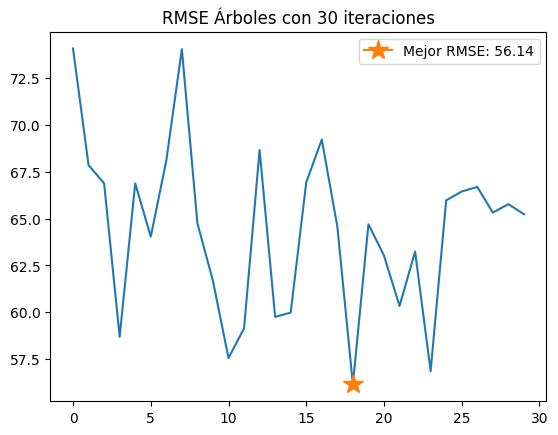

Número de características creadas para obtener el mejor RMSE: 65


In [ ]:
# %%

rmse_list = []
pred_test_list = []

for x in range(30):
    new_data = make_features(df,2*(x+1),4*(x+1))
    features_train, target_train, features_test, target_test = splitting_data(new_data)
    
    
    model = DecisionTreeRegressor(max_depth=x+1,
                                  random_state=1234)
    model.fit(features_train, target_train)

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    print(f'RMSE para el conjunto de prueba con max_lag {2*(x+1)} y max_rolling {4*(x+1)} con max_depth {x+1}: {rmse(target_test, pred_test):.2f}')

    rmse_list.append(rmse(target_test, pred_test))
rmse_list = np.array(rmse_list)
grafica_rmse(rmse_list, title="RMSE Árboles con 30 iteraciones")
print(f"Número de características creadas para obtener el mejor RMSE: {make_features(df,60,120).shape[1]-1}")

# %% [markdown]

El mejor RMSE en el modelo de Árboles fue  de 56.14, mayor a nuestro obetivo. Descartamos este modelo.
En este modelo hubo un aumentas en el parámetro max_depth.

# %% [markdown]

# Random Forest

RMSE para el conjunto de prueba con max_lag 2 y max_rolling 4 en los datos y max_depth 1 en el modelo: 74.33
RMSE para el conjunto de prueba con max_lag 4 y max_rolling 8 en los datos y max_depth 2 en el modelo: 67.39
RMSE para el conjunto de prueba con max_lag 6 y max_rolling 12 en los datos y max_depth 3 en el modelo: 61.63
RMSE para el conjunto de prueba con max_lag 8 y max_rolling 16 en los datos y max_depth 4 en el modelo: 59.47
RMSE para el conjunto de prueba con max_lag 10 y max_rolling 20 en los datos y max_depth 5 en el modelo: 58.57
RMSE para el conjunto de prueba con max_lag 12 y max_rolling 24 en los datos y max_depth 6 en el modelo: 56.20
RMSE para el conjunto de prueba con max_lag 14 y max_rolling 28 en los datos y max_depth 7 en el modelo: 55.50
RMSE para el conjunto de prueba con max_lag 16 y max_rolling 32 en los datos y max_depth 8 en el modelo: 54.85
RMSE para el conjunto de prueba con max_lag 18 y max_rolling 36 en los datos y max_depth 9 en el modelo: 53.79
RMSE pa

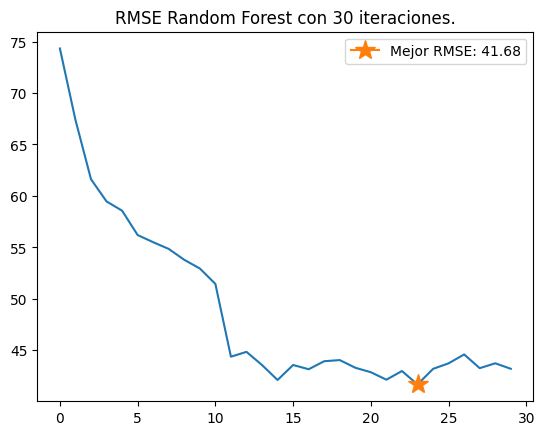

Número de características creadas para obtener el mejor RMSE: 101


<ipython-input-16-f0d4ef2fa590>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)
<ipython-input-16-f0d4ef2fa590>:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data['rolling_mean'] = (


In [ ]:
# %%

rmse_list = []
pred_test_list = []
for x in range(30):

    new_data = make_features(df,2*(x+1),4*(x+1))
    features_train, target_train, features_test, target_test = splitting_data(new_data)
    
    model = RandomForestRegressor(random_state=12345,
                                  criterion='squared_error',
                                  max_depth=x+1)
    
    model.fit(features_train, target_train.values.ravel())

    pred_test = model.predict(features_test)
    
    print(f'RMSE para el conjunto de prueba con max_lag {2*(x+1)} y max_rolling {4*(x+1)} en los datos y max_depth {x+1} en el modelo:' 
          f' {rmse(target_test, pred_test):.2f}')

    rmse_list.append(rmse(target_test, pred_test))

rmse_list = np.array(rmse_list)

grafica_rmse(rmse_list, title="RMSE Random Forest con 30 iteraciones.")
print(f"Número de características creadas para obtener el mejor RMSE: {make_features(df,96,24).shape[1]-1}")

# %% [markdown]

En Random Forest agregamos y cambiamos iterativamente el hiperparametro max_depth y como constante criterion=squared_error. Dicho esto, el mejor RMSE fue de
41.68, obvteniendo un buen resultado en el entranieminto y predicción con este modelo.

# %% [markdown]

# CatBoost

0:	learn: 37.3680388	total: 147ms	remaining: 14.6s
1:	learn: 36.2961063	total: 149ms	remaining: 7.28s
2:	learn: 35.3961969	total: 150ms	remaining: 4.85s
3:	learn: 34.7076230	total: 152ms	remaining: 3.64s
4:	learn: 34.0563282	total: 153ms	remaining: 2.91s
5:	learn: 33.5359545	total: 154ms	remaining: 2.42s
6:	learn: 33.0395966	total: 156ms	remaining: 2.07s
7:	learn: 32.6346347	total: 157ms	remaining: 1.81s
8:	learn: 32.2226556	total: 158ms	remaining: 1.6s
9:	learn: 31.8876901	total: 160ms	remaining: 1.44s
10:	learn: 31.6003880	total: 161ms	remaining: 1.3s
11:	learn: 31.3760292	total: 162ms	remaining: 1.19s
12:	learn: 31.1751904	total: 163ms	remaining: 1.09s
13:	learn: 30.9748354	total: 165ms	remaining: 1.01s
14:	learn: 30.8154676	total: 166ms	remaining: 941ms
15:	learn: 30.6557738	total: 167ms	remaining: 878ms
16:	learn: 30.5265146	total: 169ms	remaining: 823ms
17:	learn: 30.4026246	total: 170ms	remaining: 773ms
18:	learn: 30.3146228	total: 171ms	remaining: 729ms
19:	learn: 30.2175489	to

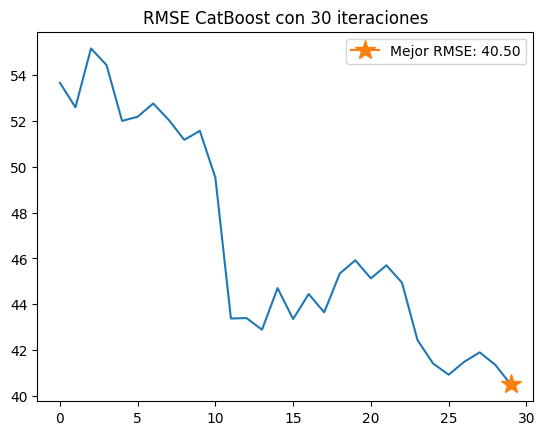

Número de características creadas para obtener el mejor RMSE: 65


In [ ]:
# %%

rmse_list = []
for x in range(30):
    
    new_data = make_features(df,2*(x+1),4*(x+1))
    features_train, target_train, features_test, target_test = splitting_data(new_data)
    model = CatBoostRegressor(depth=6,learning_rate=0.1,iterations=100)
    model.fit(features_train, target_train)
    pred_test = model.predict(features_test)
    
    print(f'RMSE para el conjunto de prueba con max_lag {2*(x+1)} y max_rolling {4*(x+1)} en los datos:' 
          f' {rmse(target_test, pred_test):.2f}')
    
    rmse_list.append(rmse(target_test, pred_test))
    
rmse_list = np.array(rmse_list)
grafica_rmse(rmse_list, title='RMSE CatBoost con 30 iteraciones')
print(f"Número de características creadas para obtener el mejor RMSE: {make_features(df,60,120).shape[1]-1}")

# %% [markdown]

Al igual que la regresión lineal obtuvimos el RMSE en la última iteración siendo 40.50. Los hiperparametros que se consideraron fueron max_depth=6,
learning_rate=0.1 y iterations=100.

# %% [markdown]

# LGBMRegressor

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11607
[LightGBM] [Info] Number of data points in the train set: 3866, number of used features: 64
[LightGBM] [Info] Start training from score 79.199431
RMSE para el conjunto de prueba con max_lag 2 y max_rolling 4 en los datos e hiperparametros max_depth 1 y num_leaves 2 en el modelo: 45.61
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11607
[LightGBM] [Info] Number of data points in the train set: 3866, number of used features: 64
[LightGBM] [Info] Start training from score 79.199431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

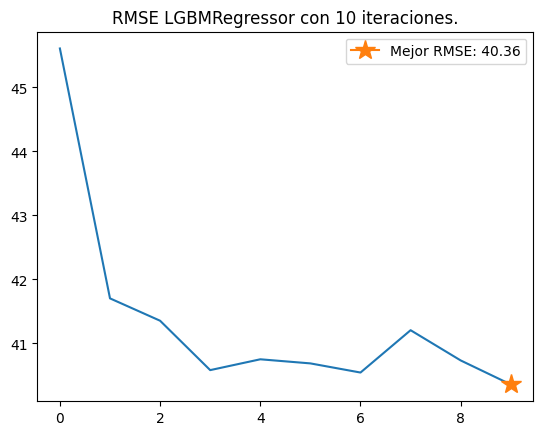

In [ ]:
# %%

rmse_list = []
for x in range(10):
    
    features_train, target_train, features_test, target_test = splitting_data(new_data)

    model = LGBMRegressor(max_depth=(x+1),num_leaves=2**(x+1))
    model.fit(features_train, target_train)
    pred_test = model.predict(features_test)
    
    print(f'RMSE para el conjunto de prueba con max_lag {2*(x+1)} y max_rolling {4*(x+1)} en los datos e hiperparametros max_depth {x+1} y num_leaves {2**(x+1)} en el modelo:' 
          f' {rmse(target_test, pred_test):.2f}')
    
    rmse_list.append(rmse(target_test, pred_test))
    
rmse_list = np.array(rmse_list)
grafica_rmse(rmse_list, title="RMSE LGBMRegressor con 10 iteraciones.")

# %% [markdown]

En el modelo LightGBM con solo 10 iteraciones obtuvimos con RMSE de 40.10.

# %% [markdown]

### XGBoost

RMSE para el conjunto de prueba con max_lag 2 y max_rolling 4 en los datos y con los hiperparametros seleccionados en el modelo: 44.31
RMSE para el conjunto de prueba con max_lag 4 y max_rolling 8 en los datos y con los hiperparametros seleccionados en el modelo: 46.15
RMSE para el conjunto de prueba con max_lag 6 y max_rolling 12 en los datos y con los hiperparametros seleccionados en el modelo: 46.28
RMSE para el conjunto de prueba con max_lag 8 y max_rolling 16 en los datos y con los hiperparametros seleccionados en el modelo: 45.94
RMSE para el conjunto de prueba con max_lag 10 y max_rolling 20 en los datos y con los hiperparametros seleccionados en el modelo: 43.72
RMSE para el conjunto de prueba con max_lag 12 y max_rolling 24 en los datos y con los hiperparametros seleccionados en el modelo: 42.86
RMSE para el conjunto de prueba con max_lag 14 y max_rolling 28 en los datos y con los hiperparametros seleccionados en el modelo: 43.16
RMSE para el conjunto de prueba con max_lag 16 

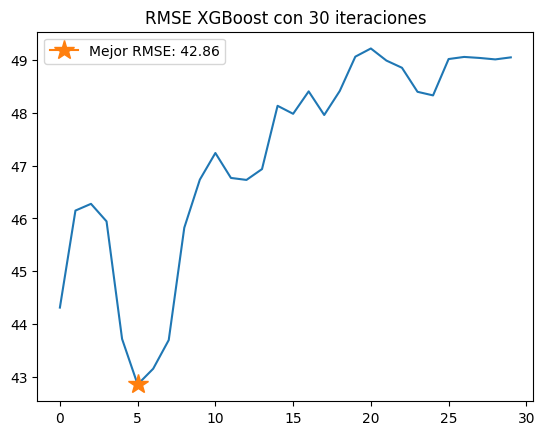

In [ ]:
# %%

rmse_list = []
for x in range(30):
    
    features_train, target_train, features_test, target_test = splitting_data(new_data)

    model =  XGBRegressor(max_depth=(x+1),
                          n_estimators = (100)*(x+1))
    model.fit(features_train, target_train)
    pred_test = model.predict(features_test)
    
    print(f'RMSE para el conjunto de prueba con max_lag {2*(x+1)} y max_rolling {4*(x+1)} en los datos y con los hiperparametros seleccionados en el modelo:' 
          f' {rmse(target_test, pred_test):.2f}')
    
    rmse_list.append(rmse(target_test, pred_test))
    
rmse_list = np.array(rmse_list)
grafica_rmse(rmse_list,title="RMSE XGBoost con 30 iteraciones")

# %% [markdown]

El mejor RMSE en XGBoost fue de 42.86 en la iteración 6 con un valor de 42.86. Además de que el RMSE vuelve aumentar después iteración al mismo tiempo que las
características y los hiperparametros.

# %% [markdown]

# Conclusión general.
Aunque la primera prueba de validación mostró un error considerablemente alto, el método de *shifting*
permitió reducir el RMSE, aunque aún no se alcanzaba el objetivo inicial de 49. A lo largo de las iteraciones
con distintos modelos, observamos mejoras en los resultados de predicción.
<br><br>
El modelo de Regresión Lineal, ajustado únicamente con cambios en las características temporales, alcanzó un
RMSE de 42.69 en la última iteración, logrando un valor por debajo del umbral de 48.
Esto lo posiciona como una opción viable para la predicción definitiva.
<br><br>
El modelo de Árboles de Decisión, aunque modificado en su parámetro `max_depth`,
no logró acercarse al objetivo, con un RMSE de 56.14, lo que sugiere que no es
adecuado para este problema.
<br><br>
Por otro lado, Random Forest, con modificaciones en el parámetro `max_depth`,
logró un RMSE de 41.68, presentando un rendimiento competitivo, similar al de
Regresión Lineal, y sería una opción sólida para la predicción.
<br><br>
Los modelos más complejos, como CatBoost y LightGBM, mostraron resultados
prometedores, alcanzando un RMSE de 40.50 y 40.10 respectivamente, lo que
indica que estos algoritmos son más eficaces para este problema.
<br><br>
Finalmente, el modelo XGBoost también logró un buen resultado con un RMSE
de 42.86, aunque mostró fluctuaciones en su rendimiento en iteraciones posteriores.
Esto sugiere que ajustes adicionales en los hiperparámetros podrían ser necesarios para estabilizar su rendimiento.
<br><br>
En conclusión, los modelos más complejos, como CatBoost y LightGBM,
son los más efectivos para alcanzar los mejores resultados de predicción,
aunque tanto Random Forest como Regresión Lineal también ofrecen soluciones robustas y eficaces.

# %% [markdown]

 Lista de revisión

# %% [markdown]

- [x] Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión.
- [x]  La *RECM* para el conjunto de prueba no es más de 48